# General workflow
This workflow is a starting point to demonstrate the functionality of the containers and to detect and classify difficult cases

In [1]:

import numpy as np
import pandas as pd
import skimage
import Images
import ModelUNet_rep
import copy



/home/lienhard/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#some definitions
debug=True #perform on a subset --> faster
model_shape=(256,256,3) #works with shape (2^x, 2^x) only?
model_name='unet_boundaries_{}x{}'.format(model_shape[0],model_shape[1])
if debug:
    model_name += '_debug'

print('the model will be called \''+model_name+'\'')


the model will be called 'unet_boundaries_256x256_debug'


## Training
* load training data
* train the model (if not yet done)
* 

100%|██████████| 18/18 [00:01<00:00, 17.47it/s]


                                                 ids  size_x  size_y  \
6  0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb...     256     256   

   n_channels  nuclei_n  nuclei_meanSz  nuclei_stdSz  nuclei_minSz  \
6           1        62            261           144            21   

   nuclei_maxSz  
6           656  


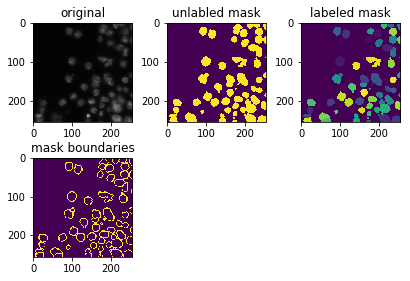

In [3]:
train=Images.Images("../input/stage1_train")
if debug:
    #subselect, to make it faster 
    train=train.subset(idx=range(20))
    #todo: overload [] to get this

#set aside 10% for validation
val=train.subset(np.arange(train.n()*.9, train.n()))
train=train.subset(np.arange(train.n()*.9,))

#load the image files (in original size)    
train.load_images()
train.load_masks()
train.features.head()    

train.show_image()

In [ ]:

#we want to learn the boundaries
trainmasks=train.masks
train.masks=copy.deepcopy(train.mask_boundaries)
valmasks=val.masks
val.masks=copy.deepcopy(val.mask_boundaries)
train.show_image()

In [4]:
# initialize and train the model 
# to detect unlabled masks (e.g. the forground vs background)


m_file=model_name+'.h5'

model=ModelUNet_rep.ModelUNet(m_file=m_file, shape=(256,256,3))
#question: should the model design be adapted according to image dimensions?
if not model.trained:
    model.fit_model(train)


Train on 16 samples, validate on 2 samples
Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.80813, saving model to unet_boundaries_256x256_debug.h5
16/16 [==============================] - 13s 786ms/step - loss: 0.8465 - mean_iou: 0.0000e+00 - val_loss: 0.8081 - val_mean_iou: 0.4031
Epoch 2/50

Epoch 00002: val_loss improved from 0.80813 to 0.78405, saving model to unet_boundaries_256x256_debug.h5
16/16 [==============================] - 9s 565ms/step - loss: 0.8251 - mean_iou: 0.4081 - val_loss: 0.7841 - val_mean_iou: 0.4084
Epoch 3/50

Epoch 00003: val_loss improved from 0.78405 to 0.75730, saving model to unet_boundaries_256x256_debug.h5
16/16 [==============================] - 9s 546ms/step - loss: 0.8088 - mean_iou: 0.4134 - val_loss: 0.7573 - val_mean_iou: 0.4148
Epoch 4/50

Epoch 00004: val_loss improved from 0.75730 to 0.69658, saving model to unet_boundaries_256x256_debug.h5
16/16 [==============================] - 8s 521ms/step - loss: 0.7914 - mean_iou: 0.4200 - val_

In [5]:

#unlabled prediction (probability of pixle belonging to forground) 
#scaled to the dimensions of the model (e.g. 256x256)
print('making predictions...')
scaled_pred=model.predict_unlabeld(train)


print('rescale probability vector...')
# rescaling performs anti-aliasing, which can disturb lable masks
# it cannot be swhiched of for my version of skimage 0.13.1, only with dev0.14
print("skimage version: {}".format(skimage.__version__))
# for the probability vector antialiasing should be rather beneficial
unlab_pred=train.rescale(scaled_pred, scale=None, dtype=np.float32, mode='reflect')

print('labeling predictions...')
pred=model.label(unlab_pred, th=0.5) #this function should also use the images
#add labled predictions to container
train.add_pred(pred)
# this adds iou scores to train.features
print( train.features.drop(['ids'], axis=1).head() ) 
print("expected LB score(train): {}".format(np.mean(train.features['iou_score'])))

train.show_image()

making predictions...
rescale probability vector...
skimage version: 0.13.1


/project/42/lienhard/github/kaggle/data-science-bowl-2018/working/Images.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if what=="images":
/project/42/lienhard/github/kaggle/data-science-bowl-2018/working/Images.py:53: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif what == "masks":


ValueError: what should be "images" or "masks"

In [ ]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
train.show_image()

In [ ]:
#same on validation data
val.load_images()
val.load_masks()
print('making predictions...')
scaled_pred=model.predict_unlabeld(val)
print('rescale probability vector...')
unlab_pred=val.rescale(scaled_pred, scale=None, dtype=np.float32, mode='reflect')
print('labeling predinctions...')
pred=model.label(unlab_pred, th=0.5) 
val.add_pred(pred)
val.features.drop(['ids'], axis=1).head()
print("expected LB score(val): {}".format(np.mean(val.features['iou_score'])))


In [ ]:
fig=plt.figure(figsize=(18, 12), dpi= 150, facecolor='w', edgecolor='k')
val.show_image()

## Prediction (on test data)
* load test data
* use model to predict masks
* prepare submission file

In [ ]:
test=Images.Images("../input/stage1_test")

#load the image files (in original size)    
test.load_images()

test.features.head()    


In [ ]:
print('making predictions...')
scaled_pred=model.predict_unlabeld(test)


print('rescale probability vector...')
unlab_pred=test.rescale(scaled_pred, scale=None, dtype=np.float32, mode='reflect')

print('labeling predinctions...')
pred=model.label(unlab_pred, th=0.5)
test.add_pred(pred)


In [ ]:
submission_file='submission' + model_name + '.csv'
test.write_submission(submission_file)



In [ ]:

##########
# scores #
##########
print('Scores for first test image:')
#unlabeled IOU
print('IoU: {}'.format(Images.iou(val.masks[0] > 0, unlab_pred[0]>0.5)))
#labled IOUs per nucleus
print('IoU per nucleus: {}'.format(Images.iou(val.masks[0], val.pred[0])))
#mean IOU
print('mean IoU: {}'.format(np.mean(Images.iou(val.masks[0], val.pred[0]))))
# fraction of nuclei > th
print('fraction of nuclei has IoU > 0.5: {}'.format(Images.iou_score(val.masks[0], val.pred[0], th=[.5])))
print('fraction of nuclei has IoU > 0.95: {}'.format(Images.iou_score(val.masks[0], val.pred[0], th=[.95])))
# fraction of nuclei > th average over range of thresholds
print('IoU score (over range of thresholds): {}'.format(Images.iou_score(val.masks[0], val.pred[0])))

val.show_image(0)